## Python Module Overview

The `Polylidar3D` and `MatrixDouble` class should be imported from the ``polylidar`` python module. The `Polyldar3D` has routines to work with 2D point sets. The `MatrixDouble` is simply a wrapper around a numpy object.

In [1]:
import time
import math

import numpy as np
from polylidar import MatrixDouble, Polylidar3D

Next polylidar has a submodule named `polyylidarutil` that has several useful utilties such as generating random 2D points sets and 2D and 3D plotting.

In [2]:
from polylidar.polylidarutil import (generate_test_points, plot_triangles, get_estimated_lmax,
                                     plot_triangle_meshes, get_triangles_from_list, get_colored_planar_segments, plot_polygons)

from polylidar.polylidarutil import (plot_polygons_3d, generate_3d_plane, set_axes_equal, plot_planes_3d,
                                     scale_points, rotation_matrix, apply_rotation)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Unorganized 2D Point Sets

First we generate two clusters of a 2D point set. Each cluster should have around 1000 points and should be about 100 units away from eachother.

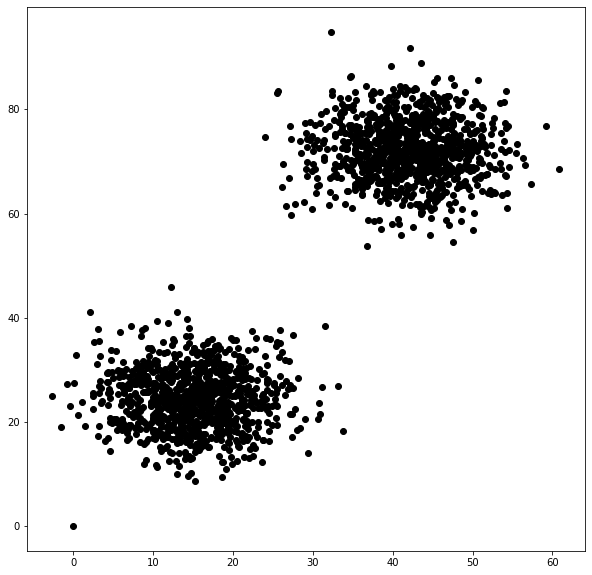

In [31]:
np.random.seed(1)
kwargs = dict(num_groups=2, group_size=1000, dist=100.0, seed=1)
points = generate_test_points(**kwargs)
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
ax.scatter(points[:, 0], points[:, 1], c='k')

Polylidar3D works by triangulating the point set and the removing triangles by edge-length contraints (and possibly other constraints) that the user specifies. The remaining triangles that are spatially connected create a *region*/*planar segment*. The polygonal representation of each segment is then extracted. 

First we configure the arguments for `Polylidar3D`. The parameter `lmax=1.8` indicates that any triangle which has an edge length greater than 1.8 will be removed. The `min_triangles` will remove any small *regions* that have too few triangles.

In [32]:
polylidar_kwargs = dict(lmax=1.8, min_triangles=20)
polylidar = Polylidar3D(**polylidar_kwargs)

Next we need to "convert" our numpy array to a format Polylidar3D understands. This is simply just a wrapper around numpy and can be specified to perfrom no copy. In other words both datastructures point to the same memory buffer. Afterwards we simply call `extract_planes_and_polygons` with `points_mat`.

In [33]:
# Convert points to matrix format (no copy) and make Polylidar3D Object
points_mat = MatrixDouble(points, copy=False)
# Extract the mesh, planes, polygons, and time
t1 = time.perf_counter()
mesh, planes, polygons = polylidar.extract_planes_and_polygons(points_mat)
t2 = time.perf_counter()
print("Took {:.2f} milliseconds".format((t2 - t1) * 1000))

Took 1.34 milliseconds


So what is mesh, planes, and polygons?  Mesh contains the 2D Delaunay triangulation of the points set. Planes is a *list* of the triangle *regions* discussed above. Finally Polygons is a list of the polygon data structure, where each polygon contains a linear ring denoting the exterior hull and list (possibly empty) of linear rings representing interior holes.

In [37]:
vertices = np.asarray(mesh.vertices) # same as points! 2000 X 2 numpy array
triangles = np.asarray(mesh.triangles) # K X 3 numpy array. Each row contains three point indices representing a triangle.
halfedges = np.asarray(mesh.halfedges) # K X 3 numpy array. Each row contains thee twin/oppoiste/shared half-edge ids of the triangle. 

print(points[:2, :])
print(vertices[:2, :])
print("")
print("First two triangles point indices")
print(triangles[:2, :])
print("")
print("First two triangles (actual points)")
print(vertices[triangles[:2, :], :])

print("")
print("A plane is just a collection of triangle indices")
assert len(planes) >= 1
plane1 = planes[0]
print("The first 10 triangle indices for the first plane:")
print(np.asarray(plane1[:10]), np.asarray(plane1).dtype)

print("")
print("A polygon has a shell and holes")
assert len(polygons) >= 1
polygon1 = polygons[0]
print("The exterior shell of the first polygon, which is associated with the first plane (point indices):")
print(np.asarray(polygon1.shell))
print("The first hole of the first polygon, which is associated with the first plane (point indices):")
print(np.asarray(polygon1.holes[0]))

[[ 0.          0.        ]
 [38.65279944 65.83766212]]
[[ 0.          0.        ]
 [38.65279944 65.83766212]]

First two triangles point indices
[[1116 1802 1510]
 [1555 1725 1802]]

First two triangles (actual points)
[[[31.4934529  38.37701172]
  [27.46622468 36.71094056]
  [25.93236998 37.66286573]]

 [[26.09863495 33.35240161]
  [25.95681833 35.0801548 ]
  [27.46622468 36.71094056]]]

A plane is just a collection of triangle indices
The first 10 triangle indices for the first plane:
[28 37 30 39 55 42 61 43 31 62] uint64

A polygon has a shell and holes
The exterior shell of the first polygon, which is associated with the first plane (point indices):
[1374 1242 1107 1200 1603 1335 1616 1148 1921 1053 1924 1650 1572 1334
 1635 1130 1132 1197 1341 1157 1817 1040 1052 1396 1244 1346 1295 1831
 1779 1173 1413 1263 1752 1985 1170 1689 1594 1077 1661 1698 1794 1227
 1947 1254 1169 1127 1633 1735 1459 1940 1456 1771 1496 1659 1820 1639
 1563 1727 1378 1601 1754 1395 1138 1280 1010 1156 10

Here we finally color code the triangle segments and plot the polygons

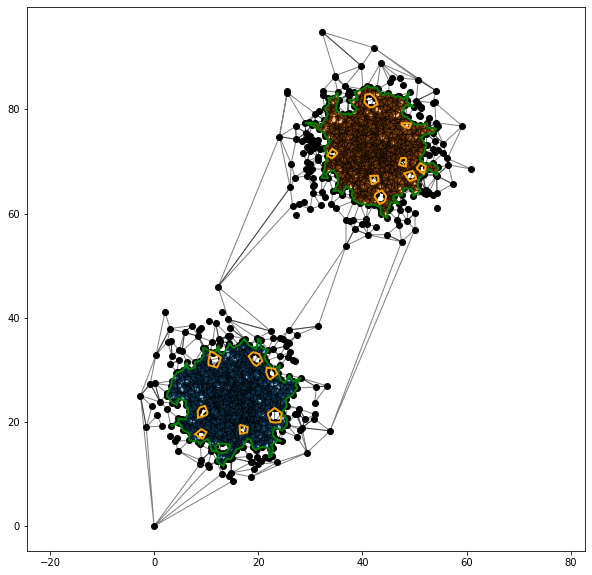

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
# plot points
ax.scatter(points[:, 0], points[:, 1], c='k')
# plot all triangles
plot_triangles(get_triangles_from_list(triangles, points), ax)
# plot seperated planar triangular segments
triangle_meshes = get_colored_planar_segments(planes, triangles, points)
plot_triangle_meshes(triangle_meshes, ax)
# plot polygons
plot_polygons(polygons, points, ax)
plt.axis('equal')
plt.show()

## Unorganized 3D Point Clouds
Polylidar3D also can create applied to unorganized 3D point clouds. Note this method is only suitable if you know the dominant surface normal of the plane you desire to extract.
The 3D point cloud must be rotated such that this surface normal is [0,0,1], i.e., the plane is aligned with the XY Plane. The method relies upon 3D->2D Projection and performs 2.5D Delaunay Triangulation. 

First we generate a simulated rooftop building with noise. Notice there are two flat surfaces, the blue points and the yellow ponts.

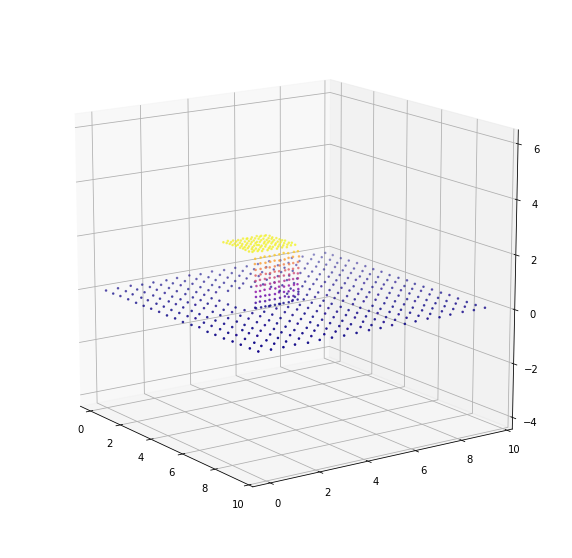

In [38]:
np.random.seed(1)
# generate random plane with hole
plane = generate_3d_plane(bounds_x=[0, 10, 0.5], bounds_y=[0, 10, 0.5], holes=[
    [[3, 5], [3, 5]]], height_noise=0.02, planar_noise=0.02)
# Generate top of box (causing the hole that we see)
box_top = generate_3d_plane(bounds_x=[3, 5, 0.2], bounds_y=[3, 5, 0.2], holes=[
], height_noise=0.02, height=2, planar_noise=0.02)
# Generate side of box (causing the hole that we see)
box_side = generate_3d_plane(bounds_x=[0, 2, 0.2], bounds_y=[
    0, 2, 0.2], holes=[], height_noise=0.02, planar_noise=0.02)
rm = rotation_matrix([0, 1, 0], -math.pi / 2.0)
box_side = apply_rotation(rm, box_side) + [5, 3, 0]
# All points joined together
points = np.concatenate((plane, box_side, box_top))

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1,
                       subplot_kw=dict(projection='3d'))
# plot points
ax.scatter(*scale_points(points), s=2.5, c=points[:, 2], cmap=plt.cm.plasma)
set_axes_equal(ax)
ax.view_init(elev=15., azim=-35)
plt.show()

Now that we are working with 3D data we have a few more options. We configure our lmax to be 1.0, but also have `z_thresh` and `norm_thresh_min`

* `z_thresh` - Maximum point to plane distance during region growing (3D only). Forces planarity constraints. A value of 0.0 ignores this constraint.                                     
* `norm_thresh_min` - Minimum value of the dot product between a triangle and surface normal being extracted. Forces planar constraints. 

The first is basically only allowing triangles be grouped together if their *vertices* fit well to a geometric plane. The later basically only allows triangles to be grouped together if they share a common *surface normal* to some degree. 

In [39]:
polylidar_kwargs = dict(alpha=0.0, lmax=1.0, min_triangles=20, z_thresh=0.1, norm_thresh_min=0.94)
polylidar = Polylidar3D(**polylidar_kwargs)

Next we extract the data and plot the results

Took 0.71 milliseconds
Should see two planes extracted, please rotate.


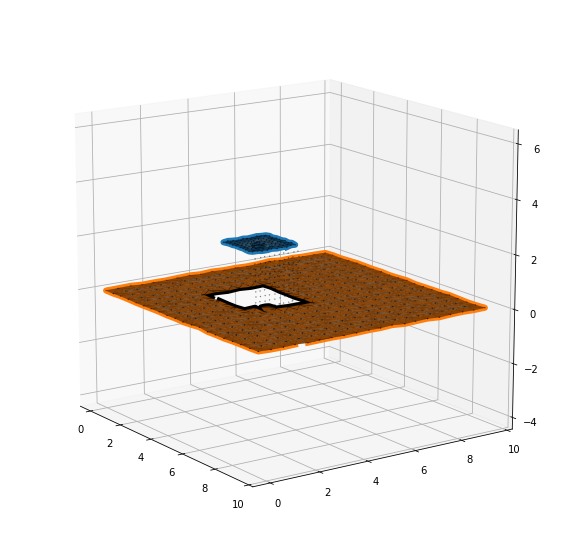

In [40]:
# Extracts planes and polygons, time
points_mat = MatrixDouble(points, copy=False)
t1 = time.time()
mesh, planes, polygons = polylidar.extract_planes_and_polygons(points_mat)
t2 = time.time()
print("Took {:.2f} milliseconds".format((t2 - t1) * 1000))
print("Should see two planes extracted, please rotate.")

triangles = np.asarray(mesh.triangles)
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1,
                       subplot_kw=dict(projection='3d'))
# plot all triangles
plot_planes_3d(points, triangles, planes, ax)
plot_polygons_3d(points, polygons, ax)
# plot points
ax.scatter(*scale_points(points), c='k', s=0.1)
set_axes_equal(ax)
ax.view_init(elev=15., azim=-35)
plt.show()
print("")